# Variational Inference: Bayesian Neural Networks

(c) 2017 by Thomas Wiecki, updated by Maxim Kochurov

Original blog post: http://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/

In [1]:
import theano
import theano.tensor as T

import pymc3 as pm
from pymc3.theanof import set_tt_rng, MRG_RandomStreams

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

from warnings import filterwarnings

/Users/julio/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%matplotlib inline

filterwarnings('ignore')
sns.set_style('white')

floatX = theano.config.floatX

set_tt_rng(MRG_RandomStreams(42))

In [3]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)
print(X.shape,Y.shape,X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(1000, 2) (1000,) (500, 2) (500, 2) (500,) (500,)


In [4]:
X.shape[1]

2

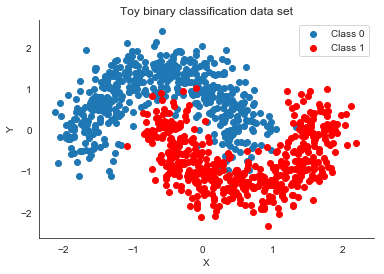

In [5]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

In [6]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5
    
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)
    
    with pm.Model() as neural_network:
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1)
        
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))

            
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1,
                               shape=(n_hidden, n_hidden),
                               testval=init_2)

        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))

        
        weights_2_out = pm.Normal('w_2_out', 0, sd=1,
                                 shape=(n_hidden,),
                                 testval=init_out)
        
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))
        
        out = pm.Bernoulli('out',
                          act_out,
                          observed=ann_output,
                          total_size=Y_train.shape[0])
        
    return neural_network

ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)
neural_network = construct_nn(ann_input, ann_output)


In [7]:
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=30000, method=inference)

Average Loss = 157.69: 100%|██████████| 30000/30000 [00:21<00:00, 1377.51it/s]
Finished [100%]: Average Loss = 157.49


In [8]:
trace = approx.sample(draws=50)

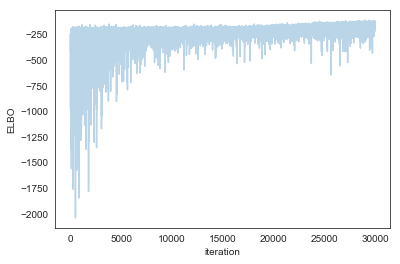

In [9]:
plt.plot(-inference.hist, label='new ADVI', alpha=.3)
plt.ylabel('ELBO')
plt.xlabel('iteration');

In [10]:
x = T.matrix('X')
n = T.iscalar('n')

x.tag.test_value = np.empty_like(X_train[:10])
n.tag.test_value = 100

_sample_proba = approx.sample_node(neural_network.out.distribution.p,
                                  size=n,
                                  more_replacements={ann_input: x})

sample_proba = theano.function([x, n], _sample_proba)


In [11]:
pred = sample_proba(X_test, 500).mean(0) > 0.5

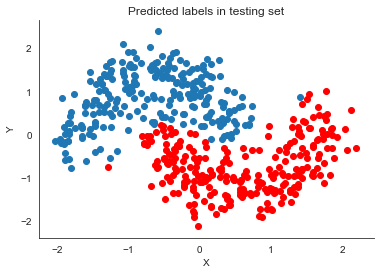

In [12]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [13]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 94.0%


In [14]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
ppc = sample_proba(grid_2d, 500)

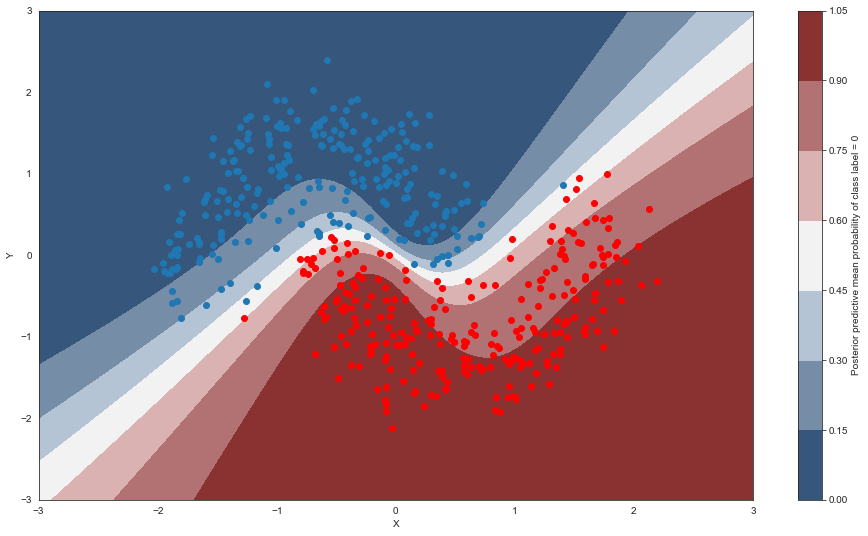

In [15]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

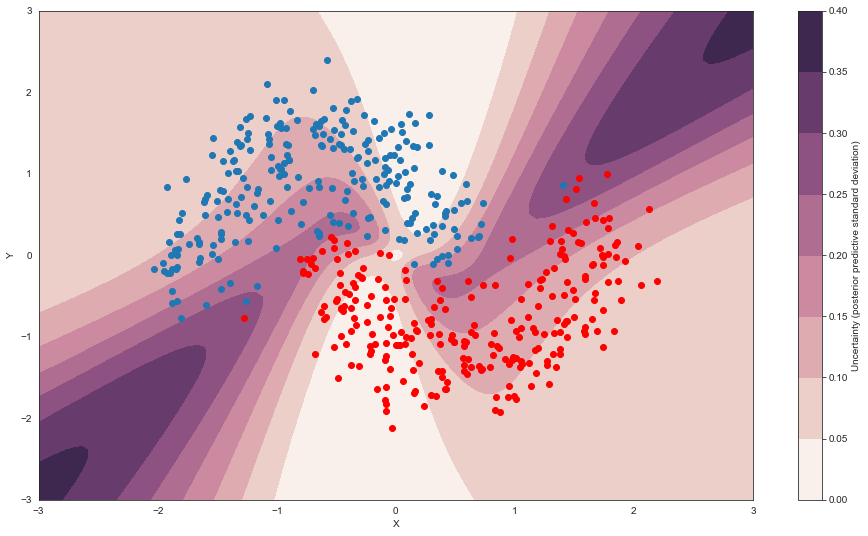

In [16]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');